In [1]:
import os
import cv2
import itertools
import librosa
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import warnings
import zipfile
# from pydub import AudioSegment
from tqdm import tqdm
from glob import glob
from PIL import Image
from google.colab import files
from google.cloud import storage
warnings.filterwarnings('ignore')

# Pytorch
import torch
import torchaudio
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchaudio.transforms import MelSpectrogram, MFCC, SpectralCentroid

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Pacotes para o relatório de hardware
import gc
import types
import pkg_resources
# import pytorch_lightning as pl

# Seed para reproduzir os mesmos resultados
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed(10)

In [2]:
device = 'cuda'

In [3]:
#!find /content/sample_data/ -type f -exec rm {} +

### Import Data

In [4]:
firts_time = True

In [5]:
if firts_time:
    uploaded = files.upload()

    for fn in uploaded.keys():
        print('User uploaded file "{name}" with length {length} bytes'.format(
            name=fn, length=len(uploaded[fn])))


Saving projetos-aleatorios-379913-61df4a1c249e.json to projetos-aleatorios-379913-61df4a1c249e.json
User uploaded file "projetos-aleatorios-379913-61df4a1c249e.json" with length 2372 bytes


In [6]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = f'/content/projetos-aleatorios-379913-61df4a1c249e.json'

In [7]:
storage_client = storage.Client()

In [8]:
bucket_name = 'projeto_musical'
rar_file_name = 'audio_data.zip'
local_rar_path = '/content/' + rar_file_name

# Define o bucket e o blob
bucket = storage_client.get_bucket(bucket_name)
blob = bucket.blob(rar_file_name)

#Baixa o arquivo RAR para o ambiente local do Colab
blob.download_to_filename(local_rar_path)

In [10]:
with zipfile.ZipFile('audio_data.zip', 'r') as zip_ref:
    # Extraindo todos os arquivos
    zip_ref.extractall('/content')

### Import dos dados e cálculo do desvio

In [11]:
labels = pd.read_csv('audio_data.csv')
labels.drop(columns='Unnamed: 0',inplace=True)

In [12]:
labels

,file_path,chord_idx
0,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
2,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
4,chords/variation_chord_audio/t_DADGBE_guitarA1...,30
...,...,...
1176055,chords/variation_chord_audio_world_noise/t_DsG...,369
1176056,chords/variation_chord_audio_world_noise/t_DsG...,369
1176057,chords/variation_chord_audio_world_noise/t_DsG...,369
1176058,chords/variation_chord_audio_world_noise/t_DsG...,369


In [13]:
analise = labels['chord_idx'].value_counts()
analise

186    6501
20     6438
303    6285
109    6278
149    6058
       ... 
227    1260
120    1242
169    1240
92     1240
197    1134
Name: chord_idx, Length: 373, dtype: int64

In [14]:
print(
    f'Media: {round(analise.mean(),2)}',
    f'Percentil 25: {round(analise.quantile(0.25),2)}',
    f'Mediana: {round(analise.median(),2)}',
    f'Percentil 75: {round(analise.quantile(0.75),2)}',
    f'Desvio Padrão: {round(analise.std(),2)}',
    f'Moda: {analise.mode()}',
    f'Max: {analise.max()}',
    f'Min: {analise.min()}',
    sep='\n'
)

Media: 3152.98
Percentil 25: 2499.0
Mediana: 3093.0
Percentil 75: 3670.0
Desvio Padrão: 934.84
Moda: 0    2310
Name: chord_idx, dtype: int64
Max: 6501
Min: 1134


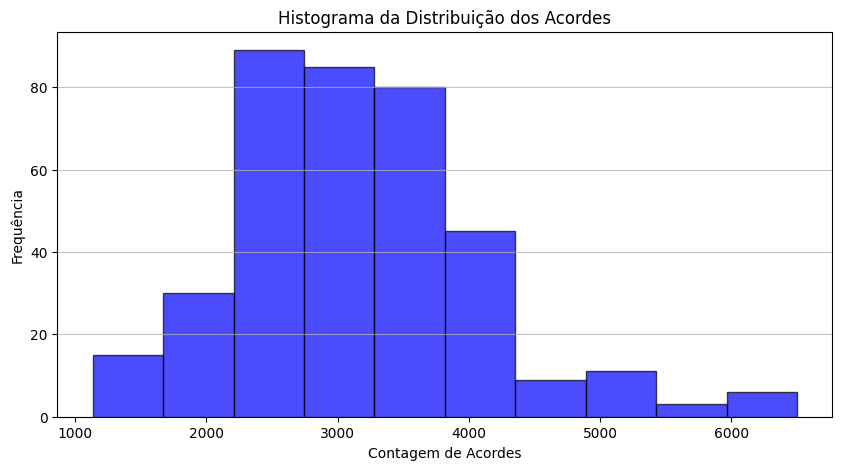

In [15]:
plt.figure(figsize=(10, 5))
plt.hist(analise, bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [16]:
target_instance = analise.quantile(0.6)
target_std = round(analise.std(),0)
# data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x),0) if x > target_instance else 0)
data_aug_rate_down = analise.apply(lambda x: target_std + round(target_std * (1-target_instance/x) * 1.4,0) if x > target_instance else 0)

In [17]:
for label, group in labels.groupby('chord_idx'):
    rate = data_aug_rate_down[label]
    if rate > 0:
        # Seleciona aleatoriamente 'rate' amostras para remover
        samples_to_remove = group.sample(n=int(rate))
        # Remove as amostras selecionadas do dataframe original
        labels = labels.drop(samples_to_remove.index)

labels.reset_index(drop=True, inplace=True)

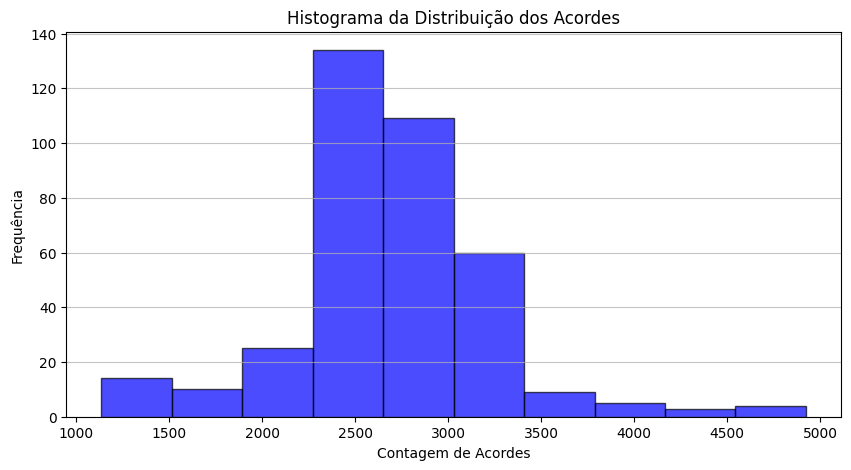

In [18]:
plt.figure(figsize=(10, 5))
plt.hist(labels['chord_idx'].value_counts(), bins=10, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histograma da Distribuição dos Acordes')
plt.xlabel('Contagem de Acordes')
plt.ylabel('Frequência')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [19]:
transforms_dict = {
    'mel_spectrogram': torchaudio.transforms.MelSpectrogram(sample_rate=22050),
    'mfcc': torchaudio.transforms.MFCC(sample_rate=22050),
    'spectral': torchaudio.transforms.SpectralCentroid(sample_rate=22050),
    'chroma': lambda x: torch.tensor(librosa.feature.chroma_stft(y=x.numpy(), sr=22050)),
    'tonnetz': lambda x: torch.tensor(librosa.feature.tonnetz(y=x.numpy(), sr=22050)),
}

In [20]:
def calculate_feature_statistics(audio_paths, feature_type):
    assert feature_type in transforms_dict, f"Feature {feature_type} is not supported."
    transform = transforms_dict[feature_type]
    sum_of_features = None
    sum_of_features_squared = None
    num_features = 0

    for path in tqdm(audio_paths):
        try:
            waveform, sample_rate = torchaudio.load(path)
            if callable(transform):
                feature = transform(waveform.squeeze(0))
            else:
                feature = transform(waveform)

            if not isinstance(feature, torch.Tensor):
                feature = torch.from_numpy(np.array(feature))

            feature_mean = feature.mean(dim=-1)
            feature_squared_mean = (feature ** 2).mean(dim=-1)

            if sum_of_features is None:
                sum_of_features = torch.zeros_like(feature_mean)
                sum_of_features_squared = torch.zeros_like(feature_mean)

            sum_of_features += feature_mean
            sum_of_features_squared += feature_squared_mean
            num_features += 1

        except RuntimeError as e:
            print(f"Failed to process {path}: {e}")

    if num_features == 0:
        raise ValueError("No features were processed. Please check your audio files and paths.")

    mean = sum_of_features / num_features
    std = (sum_of_features_squared / num_features - mean ** 2).sqrt()

    return mean, std


In [68]:
normMean, normStd = calculate_feature_statistics(labels['file_path'], 'mel_spectrogram')

100%|██████████| 1005674/1005674 [1:45:05<00:00, 159.49it/s]


In [21]:
normMean = [0.30298967, 0.11516446, 0.23933927]
normStd = [0.35485684, 0.16791199, 0.2177703 ]

In [69]:
pd.DataFrame(normMean.numpy()).to_csv('media.csv', index=False)

In [70]:
pd.DataFrame(normStd.numpy()).to_csv('desvio_pad.csv', index=False)

In [23]:
normMean = torch.tensor(pd.read_csv('media.csv').values)
normStd = torch.tensor(pd.read_csv('desvio_pad.csv').values)

In [73]:
normStd_um = normStd.clone()
normStd_um[normStd_um == 0] = 1.0
normStd_um

tensor([1.0000e+00, 1.0000e+00, 2.3980e+01, 2.0997e+01, 1.0000e+00, 5.4894e+01,
        1.2346e+02, 1.0000e+00, 3.7471e+01, 8.9507e+01, 1.0000e+00, 4.7210e+00,
        5.3450e+00, 1.0000e+00, 7.5835e+00, 1.8259e+00, 2.9016e+00, 7.0778e+00,
        1.0000e+00, 7.9841e+00, 8.3979e-01, 7.6616e+00, 4.3118e+00, 4.3685e+00,
        4.7225e+00, 6.5710e+00, 9.1408e+00, 6.6975e+00, 8.3553e+00, 8.8983e+00,
        7.1865e+00, 7.8057e+00, 2.8001e+00, 1.7022e+01, 9.6565e+00, 2.1551e+01,
        1.3250e+01, 7.4777e+00, 1.4158e+01, 7.9757e+00, 6.3267e+00, 9.1287e+00,
        7.8055e+00, 6.6308e+00, 8.0844e+00, 6.7026e+00, 3.3587e+00, 3.1373e+00,
        2.8524e+00, 2.4632e+00, 2.7362e+00, 2.2306e+00, 2.3640e+00, 1.8449e+00,
        1.4297e+00, 1.8134e+00, 3.3047e+00, 3.8301e+00, 2.8263e+00, 2.8342e+00,
        2.0275e+00, 1.5070e+00, 1.6991e+00, 1.9449e+00, 2.0999e+00, 1.9010e+00,
        2.0119e+00, 3.9626e+00, 4.9908e+00, 3.8845e+00, 2.8038e+00, 2.6342e+00,
        2.6105e+00, 2.3004e+00, 2.2418e+

In [24]:
# Lista de arquivos com erro
files_with_error = [
    "chords/variation_chord_audio_world_noise/t_DsGsCsFsAsDs_guitarEm6strum13013xDsGsCsFsAsDsv_extended_2x_v_1_c_waterfall_nature_flowing_r_0.mp3",
    # Adicione mais caminhos de arquivos aqui, se necessário
]

# Remover as linhas do DataFrame que contêm os caminhos dos arquivos com erro
labels = labels[~labels['file_path'].isin(files_with_error)]


### Funções do modelo

In [25]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [26]:
def inicializa_modelo(num_classes, feature_extract, use_pretrained=True):
    model_ft = models.densenet121(pretrained=use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)

    # Modifica a primeira camada convolucional para aceitar 1 canal de entrada (para espectrograma de mel)
    model_ft.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

    # Redefine a última camada classificadora para o número de classes desejado
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, num_classes)

    return model_ft

In [131]:
class AudioDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio_path = self.df.iloc[idx]['file_path']
        label = self.df.iloc[idx]['chord_idx']

        waveform, sample_rate = torchaudio.load(audio_path)
        mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate)(waveform)

        if self.transform:
            mel_spectrogram = self.transform(mel_spectrogram)

        # Define o tamanho alvo para a dimensão temporal
        target_size = 50

        # Aplica padding ou truncamento
        current_size = mel_spectrogram.shape[2]
        if current_size < target_size:
            padding_size = target_size - current_size
            mel_spectrogram = torch.nn.functional.pad(mel_spectrogram, (0, padding_size))
        elif current_size > target_size:
            mel_spectrogram = mel_spectrogram[:, :, :target_size]

        # Adiciona uma dimensão de canal
        # mel_spectrogram = mel_spectrogram.unsqueeze(0)

        return mel_spectrogram, label

In [28]:
# Função para calcular erro em treino e validação durante o treinamento
class CalculaMetricas(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [29]:
# Listas para erro e acurácia em treino
total_loss_train, total_acc_train = [],[]
def treina_modelo(treino_loader, model, criterion, optimizer, epoch, device):
    model.train()

    train_loss = CalculaMetricas()
    train_acc = CalculaMetricas()

    for i, (spectrograms, labels) in enumerate(treino_loader):
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(spectrograms)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        prediction = outputs.max(1, keepdim=True)[1]
        train_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / spectrograms.size(0))
        train_loss.update(loss.item())

        if (i + 1) % 100 == 0:
            print(f'[Epoch {epoch}], [Iter {i + 1} / {len(treino_loader)}], [Train Loss {train_loss.avg:.5f}], [Train Acc {train_acc.avg:.5f}]')

    return train_loss.avg, train_acc.avg

In [30]:
total_loss_val, total_acc_val = [],[]
def valida_modelo(val_loader, model, criterion, device, epoch):
    model.eval()
    val_loss = CalculaMetricas()
    val_acc = CalculaMetricas()

    with torch.no_grad():
        for i, (spectrograms, labels) in enumerate(val_loader):
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            outputs = model(spectrograms)
            prediction = outputs.max(1, keepdim=True)[1]

            val_acc.update(prediction.eq(labels.view_as(prediction)).sum().item() / spectrograms.size(0))
            val_loss.update(criterion(outputs, labels).item())

    print('------------------------------------------------------------')
    print(f'[Epoch {epoch}], [Val Loss {val_loss.avg:.5f}], [Val Acc {val_acc.avg:.5f}]')
    print('------------------------------------------------------------')

    return val_loss.avg, val_acc.avg

### Editando dataset

In [31]:
y = labels['chord_idx']
_, df_validacao = train_test_split(labels, test_size = 0.2, random_state = 101, stratify = y)

In [32]:
df_validacao.shape

(201135, 2)

In [33]:
indices_validacao = set(df_validacao.index)

# Agora definimos uma função que verifica se o índice de uma linha está nesse conjunto
def get_train_val_label(row_index):
    return 'val' if row_index in indices_validacao else 'train'

# Aplicamos essa função a cada linha do DataFrame 'labels'
labels['train_or_val'] = labels.index.map(get_train_val_label)


In [34]:
labels[labels['train_or_val'] == 'train']

,file_path,chord_idx,train_or_val
1,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
3,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
5,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
8,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
10,chords/variation_chord_audio/t_DADGBE_guitarA1...,30,train
...,...,...,...
1005672,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005673,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005674,chords/variation_chord_audio_world_noise/t_DsG...,369,train
1005675,chords/variation_chord_audio_world_noise/t_DsG...,369,train


In [35]:
# Filtra as linhas de treino
df_treino = labels[labels['train_or_val'] == 'train']

In [36]:
print(len(df_treino))
print(len(df_validacao))

804539
201135


In [37]:
df_treino['chord_idx'].value_counts()

186    3938
20     3893
303    3784
109    3778
149    3622
       ... 
227    1008
120     994
169     992
92      992
197     907
Name: chord_idx, Length: 373, dtype: int64

In [38]:
df_validacao['chord_idx'].value_counts()

186    985
20     973
303    946
109    945
149    906
      ... 
181    252
120    248
92     248
169    248
197    227
Name: chord_idx, Length: 373, dtype: int64

In [39]:
# Podemos dividir o conjunto de validação em um conjunto de validação e um conjunto de teste
df_validacao, df_teste = train_test_split(df_validacao, test_size = 0.5)

In [40]:
# Reset do índice
df_validacao = df_validacao.reset_index()
df_teste = df_teste.reset_index()

In [41]:
df_validacao.shape

(100567, 3)

In [42]:
df_teste.shape

(100568, 3)

#### Inicializando modelo

In [ ]:
# Modelo que será treinado
# nome_modelo = 'densenet'
# nome_modelo = 'resnet'
# nome_modelo = 'inception'

In [43]:
num_classes = 373

In [44]:
# Vamos treinar o modelo e sempre atualizar os pesos
feature_extract = False

In [45]:
# Inicializa o modelo
model_ft = inicializa_modelo(num_classes, feature_extract, False)

In [46]:
# Coloca o modelo no device
model = model_ft.to(device)

In [47]:
import torchaudio.transforms as T

In [48]:
target_sample_rate = 22050

In [49]:
input_size = 224

In [101]:
transform_treino = transforms.Compose([
    # T.Resample(orig_freq=22050, new_freq=3500),
    # T.TimeStretch(),
    # T.PitchShift(n_steps=30, n_fft=2048, sample_rate=target_sample_rate),
    T.FrequencyMasking(freq_mask_param=15),
    T.TimeMasking(time_mask_param=35),
    T.AmplitudeToDB(),
    # transforms.Normalize(mean=normMean, std=normStd_um)
])

In [76]:
# Transformações das imagens de validação
transform_val = transforms.Compose([
    #T.Resample(orig_freq=sr, new_freq=target_sample_rate),
    T.AmplitudeToDB(),
    transforms.Normalize(mean=normMean, std=normStd_um)
])

#### Carregando Dataloader

In [132]:
del set_treino, set_val, set_teste
del loader_treino, loader_val, loader_teste

In [133]:
# Organiza e transforma os dados de treino
set_treino = AudioDataset(df_treino, transform = transform_treino)
loader_treino = DataLoader(set_treino, batch_size = 32, shuffle = True, num_workers = 0)

In [134]:
# O mesmo em validação
set_val = AudioDataset(df_validacao, transform = transform_val)
loader_val = DataLoader(set_val, batch_size = 32, shuffle = False, num_workers = 0)

In [135]:
# O mesmo em teste
set_teste = AudioDataset(df_teste, transform = transform_val)
loader_teste = DataLoader(set_teste, batch_size = 32, shuffle = False, num_workers = 0)

In [136]:
# Usaremos o otimizador Adam
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [137]:
# Usaremos cross entropy loss como função de perda
criterion = nn.CrossEntropyLoss().to(device)

#### Treinamento

In [119]:
normMean.shape

torch.Size([128])

In [120]:
# Hiperparâmetros
epoch_num = 3
best_val_acc = 0

In [ ]:
%%time
for epoch in range(1, epoch_num + 1):

    # Execute a função de treino
    loss_train, acc_train = treina_modelo(loader_treino, model, criterion, optimizer, epoch, device)

    # Executa a função de validação
    loss_val, acc_val = valida_modelo(loader_val, model, criterion, optimizer, epoch, device)

    # Calcula as métricas
    total_loss_val.append(loss_val)
    total_acc_val.append(acc_val)

    # Verifica a acurácia em validação
    if acc_val > best_val_acc:
        best_val_acc = acc_val
        print('*****************************************************')
        print('Melhor Resultado: [epoch %d], [val loss %.5f], [val acc %.5f]' % (epoch, loss_val, acc_val))
        print('*****************************************************')

        torch.save(model.state_dict(), f'densenet_121_model_{epoch}.pth')